# Image Generation Using Denoising Diffusion Models

This notebook has been partly adapted from the excellent diffusion model [tutorial](https://huggingface.co/blog/annotated-diffusion) by Rogge & Rasul and follows the original [DDPM paper](https://arxiv.org/abs/2006.11239) by Ho et al.

### **📌 The Core Idea of Diffusion Models**
While GANs can produce high-quality results, they are notorious for unstable training. Diffusion models offer a more stable alternative. They work by reversing a gradual noising process.

1.  **Forward (Diffusion) Process**: We start with a real image and slowly add Gaussian noise over a series of timesteps (`T`). This is a fixed, non-trainable process that eventually turns the image into pure noise.

2.  **Reverse (Denoising) Process**: We train a neural network (typically a U-Net) to reverse this process. Starting from random noise, the model learns to gradually remove the noise at each timestep, ultimately generating a clean, realistic image.

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Lambda, Resize, CenterCrop, Normalize
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import kagglehub
import matplotlib.animation as animation
from matplotlib import rc

### **🔹 Model Configuration**
Here we define the key hyperparameters for our model and training process.

In [17]:
EPOCHS = 100
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
TIME_EMBEDDING_DIM = 200
TIMESTAMPS = 500
IMAGE_SIZE = 64  # Anime faces will be resized to 64x64

## 1️⃣ The Dataset: Anime Faces
- **Images**: Anime-style portrait images **(64x64, RGB)**
- **Shape**: `(batch_size, 3, 64, 64)`
- **Normalization**: Images are transformed from `[0, 255]` to `[0, 1]` (via `ToTensor`) and then to `[-1, 1]`. This normalization helps stabilize training.

In [18]:
# 使用 Compose 将一系列图像变换操作组合成一个流水线
transform_steps = Compose([
    # 1. Resize: 将图片的尺寸统一调整为 IMAGE_SIZE x IMAGE_SIZE (即 64x64)
    Resize(IMAGE_SIZE),
    # 2. CenterCrop: 从中心裁剪图片，确保最终尺寸是 64x64，去除边缘可能不规则的部分
    CenterCrop(IMAGE_SIZE),
    # 3. ToTensor: 将 PIL.Image 对象或 numpy.ndarray 转换为 PyTorch 的张量。
    #    同时，它会自动将像素值从 [0, 255] 的范围缩放到 [0, 1] 的范围。
    ToTensor(),
    # 4. Lambda: 使用一个匿名函数进行自定义变换。
    #    这里的 t 代表输入的张量 (像素值在 [0, 1])。
    #    `(t * 2) - 1` 这个操作将像素值的范围从 [0, 1] 映射到 [-1, 1]。
    Lambda(lambda t: (t * 2) - 1)
])

In [19]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("soumikrakshit/anime-faces")
print("Path to dataset files:", path)

# The dataset path will be the downloaded path
dataset_path = os.path.join(path,'data')

Path to dataset files: /kaggle/input/anime-faces


### **🔹 Custom Dataset Class**
We create a custom `Dataset` to load the image files from the directory and apply the defined transformations.

In [20]:
# 定义一个我们自己的数据集类，它继承自 PyTorch 的 torch.utils.data.Dataset
class AnimeFacesDataset(Dataset):
    # 初始化函数，在创建类的实例时调用
    # root_dir: 数据集图片所在的根目录
    # transform: 要应用到图片上的变换操作
    def __init__(self, root_dir, transform=None):
        # 保存根目录和变换操作
        self.root_dir = root_dir
        self.transform = transform
        # os.listdir(root_dir) 列出目录下的所有文件名
        # 我们用列表推导式筛选出以 .png, .jpg, .jpeg 结尾的文件，并存入 self.image_files
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # 这个方法返回数据集中的样本总数
    def __len__(self):
        return len(self.image_files)

    # 这个方法根据索引 (idx) 获取单个数据样本
    def __getitem__(self, idx):
        # 构建完整的图片文件路径
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        # 使用 PIL 打开图片，并用 .convert('RGB') 确保它是3通道的RGB图像
        image = Image.open(img_path).convert('RGB')

        # 如果定义了变换操作，就应用它
        if self.transform:
            image = self.transform(image)

        # 返回处理后的图片张量和一个虚拟标签 0。
        # 因为我们这个任务不需要标签，所以随便返回一个数字占位即可。
        return image, 0

# 创建数据集实例
# root_dir=dataset_path: 指定图片文件夹路径
# transform=transform_steps: 指定我们之前定义的预处理流程
anime_dataset = AnimeFacesDataset(root_dir=dataset_path, transform=transform_steps)
# 创建数据加载器 (DataLoader)
# anime_dataset: 要加载的数据集
# batch_size=BATCH_SIZE: 每个批次加载的图片数量
# shuffle=True: 在每个 epoch 开始时，随机打乱数据顺序，这有助于训练
train_dataloader = DataLoader(anime_dataset, batch_size=BATCH_SIZE, shuffle=True)

### **🔹 Displaying Sample Images**
Let's visualize a few images from our dataset to see what we're working with.

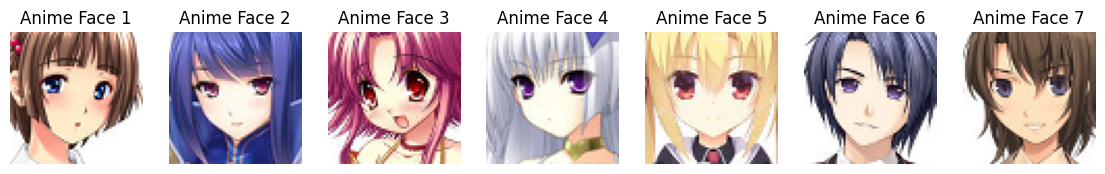

In [21]:
figure = plt.figure(figsize=(14, 14))
cols, rows = 7, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(anime_dataset), size=(1,)).item()
    img, _ = anime_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Anime Face {i}")
    plt.axis("off")
    # Convert from [-1,1] back to [0,1] for display and clamp to valid range
    img_display = np.clip((img.numpy() + 1) / 2, 0, 1)
    plt.imshow(img_display.transpose(1, 2, 0))
plt.show()

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 2️⃣ The Theory: How Diffusion Models Work

### **🔹 The Forward Diffusion Process (q)**

The forward process, denoted as `q`, is a fixed Markov chain that gradually adds Gaussian noise to an image $\mathbf{x}_0$ over `T` timesteps. The amount of noise added at each step `t` is controlled by a **variance schedule** $\{\beta_t\}_{t=1}^T$.

$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I})
$$

A key feature, which the authors call the **"nice property"**, allows us to sample a noisy image $\mathbf{x}_t$ directly from the original image $\mathbf{x}_0$ at any timestep `t`, without iterating through all the intermediate steps. This makes training very efficient.

Let $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$. Then:

$$
q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
$$

This means we can get $\mathbf{x}_t$ by taking the original image $\mathbf{x}_0$, scaling it by $\sqrt{\bar{\alpha}_t}$, and adding scaled noise $\epsilon \sim \mathcal{N}(0, I)$:

$$
\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \, \mathbf{\epsilon}
$$




## 3️⃣ The Model: A U-Net for Noise Prediction

The model architecture needs to take a noisy image and a timestep as input and output a tensor of the same shape as the image (the predicted noise). A **U-Net** is perfectly suited for this task.

### **🔹 Key Architectural Components**
1.  **Downsampling Path**: A series of convolutional layers that reduce the spatial dimensions of the image, capturing contextual information.
2.  **Bottleneck**: A set of linear layers that process the flattened feature map.
3.  **Upsampling Path**: A series of transposed convolutional layers that increase the spatial dimensions back to the original image size.
4.  **Skip Connections**: Connections that link layers from the downsampling path to corresponding layers in the upsampling path. This is crucial for preserving high-frequency details and helps the model reconstruct the image accurately.
5.  **Time Embeddings**: Since the model needs to know *which* noise level `t` it's dealing with, we convert the scalar timestep `t` into a vector using **Sinusoidal Position Embeddings**. This vector is then incorporated into each block of the U-Net.

### **🔹 Helper Blocks for the U-Net**
First, we define the building blocks of our U-Net: convolutional blocks, upsampling blocks, and the time embedding module.

In [23]:
# 定义一个卷积块 (ConvBlock)，继承自 nn.Module
class ConvBlock(nn.Module):
  """卷积块，集成了时间嵌入。"""
  # 初始化函数
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, time_emb_dim, last=False):
    # 调用父类的初始化
    super(ConvBlock, self).__init__()
    self.last = last  # 标记是否为最后一层
    # 一个线性层，用于将时间嵌入向量 t 映射到与输入通道数相同的维度
    self.time_mlp = nn.Linear(time_emb_dim, in_channels)
    # 核心的二维卷积层
    self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    # 如果不是最后一层，则添加批量归一化和激活函数
    if not self.last:
      self.batch_norm_layer = nn.BatchNorm2d(out_channels)
      self.act = nn.LeakyReLU()

  # 前向传播函数
  def forward(self, x, t):
    # 1. 将时间步 t 通过线性层进行变换
    t_emb = self.time_mlp(t) # self.time_mlp 的作用是将这个时间步 t 转换为一个有意义的向量
    # 2. 将变换后的时间嵌入加到输入的特征图 x 上。
    #    t_emb 原本是二维的 (batch_size, channels)，需要用 .view() 把它变成四维 (batch_size, channels, 1, 1)
    #    才能和四维的特征图 x (batch, channels, height, width) 相加。
    x = x + t_emb.view(*t_emb.shape, 1, 1)
    # 3. 通过卷积层
    x = self.conv_layer(x)
    # 4. 如果不是最后一层，应用批量归一化和激活函数
    if not self.last:
      x = self.batch_norm_layer(x)
      x = self.act(x)
    return x

  # 我们通过“将时间嵌入加到每个像素上”这个动作，就像是给油漆工手里的工具（或者他面前的家具）打上了一个无形的标签，告诉他：“嘿，这是第一批/最后一批！”
  # 这个“标签”虽然只是一个数值，但对于高度复杂的神经网络来说，足以让它区分不同的处理阶段，并执行适应当前阶段的最佳操作。
  # 这就是为什么通过相加这个时间嵌入，我们实际上是在“告诉”模型当前是去噪的早期阶段。

# 定义一个上采样块 (UpSampleBlock)，与 ConvBlock 类似，但使用转置卷积
class UpSampleBlock(nn.Module):
  """上采样块，集成了时间嵌入。"""
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding, time_emb_dim, last=False):
    super(UpSampleBlock, self).__init__()
    self.last = last
    self.time_mlp = nn.Linear(time_emb_dim, in_channels)
    # 使用转置卷积 (ConvTranspose2d) 来进行上采样，放大特征图
    self.conv_trans_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding)
    if not self.last:
      self.batch_norm_layer = nn.BatchNorm2d(out_channels)
      self.act = nn.LeakyReLU()

  def forward(self, x, t):
    t_emb = self.time_mlp(t)
    x = x + t_emb.view(*t_emb.shape, 1, 1)
    x = self.conv_trans_layer(x)
    if not self.last:
      x = self.batch_norm_layer(x)
      x = self.act(x)
    return x

# 定义一个线性块 (LinearBlock)，用于U-Net的瓶颈部分
class LinearBlock(nn.Module):
  """用于瓶颈部分的线性块，集成了时间嵌入。"""
  def __init__(self, in_dim, out_dim, time_emb_dim):
    super(LinearBlock, self).__init__()
    self.time_mlp = nn.Linear(time_emb_dim, in_dim)
    self.linear_layer = nn.Linear(in_dim, out_dim)
    # BatchNorm1d 用于处理一维数据（在瓶颈处特征图被展平了）
    self.batch_norm_layer = nn.BatchNorm1d(out_dim)
    self.act = nn.LeakyReLU()

  def forward(self, x, t):
    t_emb = self.time_mlp(t)
    # 直接将时间嵌入加到展平的特征向量上
    x = x + t_emb
    x = self.linear_layer(x)
    x = self.batch_norm_layer(x)
    x = self.act(x)
    return x

# 定义正弦位置嵌入模块
class SinusoidalPositionEmbeddings(nn.Module):
    """将时间步 t 编码成一个高维向量。"""
    def __init__(self, dim):
      super(SinusoidalPositionEmbeddings, self).__init__()
      self.dim = dim

    def forward(self, time):
      device = time.device  # 获取张量所在的设备 (CPU/GPU)
      half_dim = self.dim // 2
      # 计算嵌入的频率。这是Transformer论文中的标准公式。
      embeddings = np.log(10000) / (half_dim - 1)
      embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
      # 将时间和频率相乘
      embeddings = time[:, None] * embeddings[None, :]
      # 将 sin 和 cos 变换后的结果拼接起来，构成最终的位置嵌入
      embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
      return embeddings

### **🔹 The Full Diffusion Model**
Now we assemble the blocks into the full U-Net architecture.

- **Input**: A batch of noisy images `x` of shape `(batch_size, 3, 64, 64)` and their corresponding timesteps `t` of shape `(batch_size,)`.
- **Output**: A tensor of predicted noise `ε_θ` with the same shape as the input image: `(batch_size, 3, 64, 64)`.

In [24]:
# 一个自定义的 Reshape 层，用于在网络中改变张量的形状
class Reshape(nn.Module):
  """自定义的 Reshape 层。"""
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape
  def forward(self, x):
    return x.view(*self.shape)

# 完整的扩散模型类
class DiffusionModel(nn.Module):
    """具有U-Net架构的扩散模型，用于RGB图像。"""
    def __init__(self, time_emb_dim):
        super(DiffusionModel, self).__init__()
        self.time_emb_dim = time_emb_dim

        # === 时间嵌入模型 ===
        # 首先，将时间步 t 转换为时间嵌入向量
        self.time_embedding_model = nn.Sequential(
            SinusoidalPositionEmbeddings(200),  # 先进行正弦位置编码
            nn.Linear(200, time_emb_dim),      # 线性层
            nn.LeakyReLU(),                     # 激活函数
            nn.Linear(time_emb_dim, time_emb_dim) # 再一个线性层
        )

        # === 编码器 (下采样路径) ===
        # in_channels: 输入通道数, out_channels: 输出通道数
        self.dsb_1 = ConvBlock(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2, time_emb_dim=time_emb_dim) # 64x64 -> 32x32
        self.conv1 = ConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
        self.dsb_2 = ConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, time_emb_dim=time_emb_dim) # 32x32 -> 16x16
        self.conv2 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
        self.dsb_3 = ConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, time_emb_dim=time_emb_dim) # 16x16 -> 8x8

        # 将多维特征图展平为一维向量，以输入到线性层
        self.flatten = nn.Flatten(1,-1)

        # === 瓶颈部分 (Bottleneck) ===
        self.linear_1 = LinearBlock(in_dim=512*8*8, out_dim=512, time_emb_dim=time_emb_dim)
        self.linear_2 = LinearBlock(in_dim=512, out_dim=256, time_emb_dim=time_emb_dim)
        self.linear_3 = LinearBlock(in_dim=256, out_dim=512, time_emb_dim=time_emb_dim)
        self.linear_4 = LinearBlock(in_dim=512, out_dim=512*8*8, time_emb_dim=time_emb_dim)

        # 将一维向量重新塑形为四维特征图，以输入到解码器
        self.reshape = Reshape((-1,512,8,8))

        # === 解码器 (上采样路径) ===
        # output_padding: 转置卷积中用于精确控制输出尺寸的参数
        self.usb_1 = UpSampleBlock(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1, time_emb_dim=time_emb_dim) # 8x8 -> 16x16
        self.conv3 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
        self.usb_2 = UpSampleBlock(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, time_emb_dim=time_emb_dim) # 16x16 -> 32x32
        self.conv4 = ConvBlock(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
        self.usb_3 = UpSampleBlock(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=2, output_padding=1, time_emb_dim=time_emb_dim) # 32x32 -> 64x64
        self.conv5 = ConvBlock(in_channels=32, out_channels=3, kernel_size=1, stride=1, padding=0, time_emb_dim=time_emb_dim, last=True) # 最终输出层，输出3通道图像

    # 定义模型的前向传播逻辑
    def forward(self, x, t):
        # 1. 获取时间嵌入
        t = self.time_embedding_model(t)

        # 2. 通过编码器，并保存每一层的输出用于跳跃连接
        x1 = self.dsb_1(x, t)    # -> (64, 32, 32)
        x2 = self.conv1(x1, t)   # -> (128, 32, 32)
        x3 = self.dsb_2(x2, t)   # -> (256, 16, 16)
        x4 = self.conv2(x3, t)   # -> (256, 16, 16)
        x5 = self.dsb_3(x4, t)   # -> (512, 8, 8)

        # 3. 通过瓶颈部分
        x5_ = self.flatten(x5)
        x6 = self.linear_1(x5_, t)
        x7 = self.linear_2(x6, t)
        x = self.linear_3(x7, t)
        x = self.linear_4(x+x6, t) # 在瓶颈处也使用了一个跳跃连接
        x = self.reshape(x)

        # 4. 通过解码器，并使用跳跃连接（将编码器的输出和解码器的输入相加）
        x = self.usb_1(x+x5, t)  # 与 x5 跳跃连接
        x = self.conv3(x+x4, t)  # 与 x4 跳跃连接
        x = self.usb_2(x+x3, t)  # 与 x3 跳跃连接
        x = self.conv4(x+x2, t)  # 与 x2 跳跃连接
        x = self.usb_3(x+x1, t)  # 与 x1 跳跃连接
        x = self.conv5(x, t)     # 最终输出预测的噪声

        return x

In [25]:
model = DiffusionModel(time_emb_dim=TIME_EMBEDDING_DIM)
model.to(device)

DiffusionModel(
  (time_embedding_model): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=200, out_features=200, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=200, out_features=200, bias=True)
  )
  (dsb_1): ConvBlock(
    (time_mlp): Linear(in_features=200, out_features=3, bias=True)
    (conv_layer): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (batch_norm_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.01)
  )
  (conv1): ConvBlock(
    (time_mlp): Linear(in_features=200, out_features=64, bias=True)
    (conv_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_layer): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.01)
  )
  (dsb_2): ConvBlock(
    (time_mlp): Linear(in_features=200, out_features=128, bias=True)


## 4️⃣ The Diffusion Process & Loss Function

### **🔹 Pre-calculating The Diffusion Schedule**

We need to define the variance schedule $\{\beta_t\}_{t=1}^T$. A simple linear schedule works well. From $\beta_t$, we can pre-calculate all the $\alpha_t$ and $\bar{\alpha}_t$ values needed for the forward process (`q_sample`) and the reverse sampling process.


In [26]:
# 定义一个函数来生成线性的 beta 调度
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    # torch.linspace 生成一个从 beta_start 到 beta_end 的等差数列，长度为 timesteps
    return torch.linspace(beta_start, beta_end, timesteps)

# 生成 betas (β)
betas = linear_beta_schedule(timesteps=TIMESTAMPS)

# 根据 betas (β) 计算其他所有需要的参数
# alphas (α_t = 1 - β_t)
alphas = 1. - betas
# alphas_cumprod (ᾱ_t = Π α_s)，torch.cumprod 计算累积乘积
alphas_cumprod = torch.cumprod(alphas, axis=0)
# alphas_cumprod_prev (ᾱ_{t-1})，F.pad 用于在张量开头填充一个 1.0
alphas_cumprod_prev = nn.functional.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
# sqrt_recip_alphas (1 / sqrt(α_t))，用于采样过程
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# 用于前向扩散过程 q(x_t | x_0) 的计算
# sqrt(ᾱ_t)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
# sqrt(1 - ᾱ_t)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# 用于计算后验分布 q(x_{t-1} | x_t, x_0) 的方差，在采样时使用
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# 定义一个辅助函数，用于根据时间步 t 从预计算的张量 a 中提取对应的值
def extract(a, t, x_shape):
    """帮助函数，为一批时间步提取正确的 alpha/beta 值。"""
    batch_size = t.shape[0] # 获取批大小
    # a.gather(-1, t.cpu()) 会根据 t 中的索引，在 a 中查找对应的值
    # .cpu() 是因为 gather 操作可能需要在CPU上执行索引
    out = a.gather(-1, t.cpu())
    # 将提取出的值 reshape 成可以和批次中每张图片进行广播操作的形状
    # 例如，(batch_size, 1, 1, 1)，然后移动到 t 所在的设备
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


### **🔹 The Forward Pass (`q_sample`)**

This function implements the "nice property" described earlier. It takes an original image `x_start` and a timestep `t` and returns a noisy version of the image at that timestep, $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \, \mathbf{\epsilon}$



In [27]:
# 前向扩散过程（使用“捷径”属性）
def q_sample(x_start, t, noise=None):
    # 如果没有提供噪声，就生成一个和输入图片 x_start 形状相同的标准高斯噪声
    if noise is None:
        noise = torch.randn_like(x_start)

    # 使用 extract 函数提取当前时间步 t 对应的 sqrt(ᾱ_t) 值
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    # 提取当前时间步 t 对应的 sqrt(1 - ᾱ_t) 值
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    # 应用公式: x_t = sqrt(ᾱ_t) * x_0 + sqrt(1 - ᾱ_t) * ε
    # * 操作是逐元素相乘
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

### **🔹 The Loss Function (`p_losses`)**
This function defines our training objective. For a given batch of images:
1.  A random noise tensor `noise` is created.
2.  A noisy version of the image, `x_noisy`, is created using `q_sample`.
3.  The model predicts the noise, `predicted_noise`, from `x_noisy`.
4.  The loss is the `smooth_l1_loss` (a robust version of MSE) between the `noise` and `predicted_noise`.

In [28]:
# 定义损失函数
def p_losses(denoise_model, x_start, t, noise=None):
    # 如果没有提供噪声，就生成一个
    if noise is None:
        noise = torch.randn_like(x_start)

    # 1. 生成加噪图片 x_noisy
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    # 2. 让模型从 x_noisy 预测噪声
    predicted_noise = denoise_model(x_noisy, t)

    # 3. 计算真实噪声和预测噪声之间的损失
    # smooth_l1_loss 是一种鲁棒性比L2损失（MSE）更好的损失函数
    loss = nn.functional.smooth_l1_loss(noise, predicted_noise)

    return loss

## 5️⃣ Training the Model
Now we're ready to train. The training loop performs the following steps for each batch:

1.  Load a batch of real images.
2.  For each image, sample a random timestep `t` from `0` to `T-1`.
3.  Calculate the loss using our `p_losses` function.
4.  Perform backpropagation to compute gradients.
5.  Update the model's weights using the optimizer.

In [29]:
# Defining the optimizer here
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Lists to store loss history for plotting
train_losses = []
epoch_losses = []

In [30]:
# 外层循环，遍历所有 epochs
for i in range(1, EPOCHS+1):
    running_loss = 0
    epoch_loss = 0     # 初始化当前 epoch 的总损失
    batch_count = 0  # 初始化当前 epoch 的批次计数器

    # 使用 tqdm 包装数据加载器，以显示进度条
    pbar = tqdm(train_dataloader)
    # 内层循环，遍历一个 epoch 中的所有批次
    for b, data in enumerate(pbar):
        # data 是一个包含输入和标签的元组，我们只需要输入（图片）
        inputs, _ = data
        # 将输入数据移动到指定的计算设备 (GPU/CPU)
        inputs = inputs.to(device)

        # 在每次计算梯度之前，清空之前的梯度！这是 PyTorch 的标准操作。
        optimizer.zero_grad()

        # 为批次中的每张图片采样一个随机的时间步 t
        # torch.randint(low, high, size, ...): 生成在 [low, high) 区间的随机整数
        t = torch.randint(0, TIMESTAMPS, (inputs.shape[0],), device=device).long()

        # 计算损失
        loss = p_losses(model, inputs, t)
        # 反向传播，计算损失相对于模型所有参数的梯度
        loss.backward()

        # 根据计算出的梯度，更新模型的权重
        optimizer.step()

        # --- 损失跟踪和进度条更新 ---
        # loss.item() 获取损失的标量值
        batch_loss = loss.item()
        # 将当前批次的损失添加到列表中
        train_losses.append(batch_loss)
        # 累加 epoch 的总损失
        epoch_loss += batch_loss
        # 批次计数器加一
        batch_count += 1

        # 更新 tqdm 进度条的描述和后缀信息
        pbar.set_description(f"Epoch {i}/{EPOCHS}")
        pbar.set_postfix({"batch_loss": batch_loss, "avg_epoch_loss": epoch_loss/batch_count})

    # 一个 epoch 结束后，计算并存储平均损失
    avg_epoch_loss = epoch_loss / batch_count
    epoch_losses.append(avg_epoch_loss)
    # 打印当前 epoch 的平均损失
    print(f"Epoch {i} - Average Loss: {avg_epoch_loss:.6f}")

Epoch 1/100: 100%|██████████| 169/169 [02:31<00:00,  1.12it/s, batch_loss=0.0751, avg_epoch_loss=0.119]


Epoch 1 - Average Loss: 0.118719


Epoch 2/100: 100%|██████████| 169/169 [00:34<00:00,  4.92it/s, batch_loss=0.0681, avg_epoch_loss=0.0648]


Epoch 2 - Average Loss: 0.064815


Epoch 3/100: 100%|██████████| 169/169 [00:34<00:00,  4.93it/s, batch_loss=0.057, avg_epoch_loss=0.0577]


Epoch 3 - Average Loss: 0.057672


Epoch 4/100: 100%|██████████| 169/169 [00:34<00:00,  4.96it/s, batch_loss=0.0566, avg_epoch_loss=0.0538]


Epoch 4 - Average Loss: 0.053846


Epoch 5/100: 100%|██████████| 169/169 [00:34<00:00,  4.96it/s, batch_loss=0.0523, avg_epoch_loss=0.0585]


Epoch 5 - Average Loss: 0.058532


Epoch 6/100: 100%|██████████| 169/169 [00:34<00:00,  4.89it/s, batch_loss=0.0518, avg_epoch_loss=0.0511]


Epoch 6 - Average Loss: 0.051128


Epoch 7/100: 100%|██████████| 169/169 [00:33<00:00,  5.01it/s, batch_loss=0.0666, avg_epoch_loss=0.0497]


Epoch 7 - Average Loss: 0.049726


Epoch 8/100: 100%|██████████| 169/169 [00:33<00:00,  5.09it/s, batch_loss=0.0444, avg_epoch_loss=0.0492]


Epoch 8 - Average Loss: 0.049222


Epoch 9/100: 100%|██████████| 169/169 [00:33<00:00,  5.12it/s, batch_loss=0.0486, avg_epoch_loss=0.0457]


Epoch 9 - Average Loss: 0.045702


Epoch 10/100: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s, batch_loss=0.0666, avg_epoch_loss=0.0458]


Epoch 10 - Average Loss: 0.045826


Epoch 11/100: 100%|██████████| 169/169 [00:33<00:00,  5.11it/s, batch_loss=0.0386, avg_epoch_loss=0.0446]


Epoch 11 - Average Loss: 0.044560


Epoch 12/100: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s, batch_loss=0.0517, avg_epoch_loss=0.044]


Epoch 12 - Average Loss: 0.043978


Epoch 13/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.048, avg_epoch_loss=0.0421]


Epoch 13 - Average Loss: 0.042136


Epoch 14/100: 100%|██████████| 169/169 [00:32<00:00,  5.16it/s, batch_loss=0.048, avg_epoch_loss=0.0417]


Epoch 14 - Average Loss: 0.041677


Epoch 15/100: 100%|██████████| 169/169 [00:33<00:00,  5.05it/s, batch_loss=0.0339, avg_epoch_loss=0.0422]


Epoch 15 - Average Loss: 0.042226


Epoch 16/100: 100%|██████████| 169/169 [00:33<00:00,  5.07it/s, batch_loss=0.0406, avg_epoch_loss=0.0416]


Epoch 16 - Average Loss: 0.041583


Epoch 17/100: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s, batch_loss=0.0447, avg_epoch_loss=0.0417]


Epoch 17 - Average Loss: 0.041679


Epoch 18/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.031, avg_epoch_loss=0.0437]


Epoch 18 - Average Loss: 0.043739


Epoch 19/100: 100%|██████████| 169/169 [00:33<00:00,  5.11it/s, batch_loss=0.033, avg_epoch_loss=0.04]


Epoch 19 - Average Loss: 0.040007


Epoch 20/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.0341, avg_epoch_loss=0.0403]


Epoch 20 - Average Loss: 0.040313


Epoch 21/100: 100%|██████████| 169/169 [00:33<00:00,  5.10it/s, batch_loss=0.0343, avg_epoch_loss=0.0394]


Epoch 21 - Average Loss: 0.039412


Epoch 22/100: 100%|██████████| 169/169 [00:33<00:00,  5.11it/s, batch_loss=0.0587, avg_epoch_loss=0.0394]


Epoch 22 - Average Loss: 0.039420


Epoch 23/100: 100%|██████████| 169/169 [00:33<00:00,  5.11it/s, batch_loss=0.0334, avg_epoch_loss=0.0399]


Epoch 23 - Average Loss: 0.039946


Epoch 24/100: 100%|██████████| 169/169 [00:33<00:00,  5.09it/s, batch_loss=0.0317, avg_epoch_loss=0.0384]


Epoch 24 - Average Loss: 0.038450


Epoch 25/100: 100%|██████████| 169/169 [00:32<00:00,  5.15it/s, batch_loss=0.0423, avg_epoch_loss=0.0382]


Epoch 25 - Average Loss: 0.038234


Epoch 26/100: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s, batch_loss=0.0324, avg_epoch_loss=0.0381]


Epoch 26 - Average Loss: 0.038071


Epoch 27/100: 100%|██████████| 169/169 [00:33<00:00,  5.09it/s, batch_loss=0.0336, avg_epoch_loss=0.038]


Epoch 27 - Average Loss: 0.037979


Epoch 28/100: 100%|██████████| 169/169 [00:33<00:00,  5.06it/s, batch_loss=0.0332, avg_epoch_loss=0.0371]


Epoch 28 - Average Loss: 0.037147


Epoch 29/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.037, avg_epoch_loss=0.037]


Epoch 29 - Average Loss: 0.036953


Epoch 30/100: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s, batch_loss=0.0375, avg_epoch_loss=0.0367]


Epoch 30 - Average Loss: 0.036720


Epoch 31/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.0268, avg_epoch_loss=0.0367]


Epoch 31 - Average Loss: 0.036707


Epoch 32/100: 100%|██████████| 169/169 [00:33<00:00,  5.06it/s, batch_loss=0.0296, avg_epoch_loss=0.037]


Epoch 32 - Average Loss: 0.036955


Epoch 33/100: 100%|██████████| 169/169 [00:32<00:00,  5.12it/s, batch_loss=0.0386, avg_epoch_loss=0.0365]


Epoch 33 - Average Loss: 0.036535


Epoch 34/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.0308, avg_epoch_loss=0.0363]


Epoch 34 - Average Loss: 0.036281


Epoch 35/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.0289, avg_epoch_loss=0.0362]


Epoch 35 - Average Loss: 0.036209


Epoch 36/100: 100%|██████████| 169/169 [00:32<00:00,  5.17it/s, batch_loss=0.0346, avg_epoch_loss=0.0357]


Epoch 36 - Average Loss: 0.035682


Epoch 37/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.0669, avg_epoch_loss=0.036]


Epoch 37 - Average Loss: 0.035992


Epoch 38/100: 100%|██████████| 169/169 [00:32<00:00,  5.22it/s, batch_loss=0.036, avg_epoch_loss=0.0352]


Epoch 38 - Average Loss: 0.035153


Epoch 39/100: 100%|██████████| 169/169 [00:33<00:00,  5.10it/s, batch_loss=0.0296, avg_epoch_loss=0.0355]


Epoch 39 - Average Loss: 0.035531


Epoch 40/100: 100%|██████████| 169/169 [00:32<00:00,  5.17it/s, batch_loss=0.0379, avg_epoch_loss=0.0355]


Epoch 40 - Average Loss: 0.035484


Epoch 41/100: 100%|██████████| 169/169 [00:32<00:00,  5.20it/s, batch_loss=0.0716, avg_epoch_loss=0.0356]


Epoch 41 - Average Loss: 0.035634


Epoch 42/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.0213, avg_epoch_loss=0.036]


Epoch 42 - Average Loss: 0.036048


Epoch 43/100: 100%|██████████| 169/169 [00:32<00:00,  5.17it/s, batch_loss=0.0697, avg_epoch_loss=0.0356]


Epoch 43 - Average Loss: 0.035575


Epoch 44/100: 100%|██████████| 169/169 [00:32<00:00,  5.18it/s, batch_loss=0.034, avg_epoch_loss=0.0348]


Epoch 44 - Average Loss: 0.034838


Epoch 45/100: 100%|██████████| 169/169 [00:32<00:00,  5.19it/s, batch_loss=0.0281, avg_epoch_loss=0.0347]


Epoch 45 - Average Loss: 0.034716


Epoch 46/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.0488, avg_epoch_loss=0.0357]


Epoch 46 - Average Loss: 0.035667


Epoch 47/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.0416, avg_epoch_loss=0.0356]


Epoch 47 - Average Loss: 0.035551


Epoch 48/100: 100%|██████████| 169/169 [00:33<00:00,  5.10it/s, batch_loss=0.0574, avg_epoch_loss=0.0342]


Epoch 48 - Average Loss: 0.034224


Epoch 49/100: 100%|██████████| 169/169 [00:32<00:00,  5.16it/s, batch_loss=0.0301, avg_epoch_loss=0.0335]


Epoch 49 - Average Loss: 0.033486


Epoch 50/100: 100%|██████████| 169/169 [00:33<00:00,  5.06it/s, batch_loss=0.0346, avg_epoch_loss=0.0333]


Epoch 50 - Average Loss: 0.033278


Epoch 51/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.0363, avg_epoch_loss=0.0339]


Epoch 51 - Average Loss: 0.033924


Epoch 52/100: 100%|██████████| 169/169 [00:32<00:00,  5.15it/s, batch_loss=0.0317, avg_epoch_loss=0.0345]


Epoch 52 - Average Loss: 0.034473


Epoch 53/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.0194, avg_epoch_loss=0.0344]


Epoch 53 - Average Loss: 0.034413


Epoch 54/100: 100%|██████████| 169/169 [00:33<00:00,  5.11it/s, batch_loss=0.0261, avg_epoch_loss=0.0337]


Epoch 54 - Average Loss: 0.033695


Epoch 55/100: 100%|██████████| 169/169 [00:33<00:00,  5.12it/s, batch_loss=0.0326, avg_epoch_loss=0.0341]


Epoch 55 - Average Loss: 0.034089


Epoch 56/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.0404, avg_epoch_loss=0.0337]


Epoch 56 - Average Loss: 0.033679


Epoch 57/100: 100%|██████████| 169/169 [00:33<00:00,  5.09it/s, batch_loss=0.0249, avg_epoch_loss=0.033]


Epoch 57 - Average Loss: 0.033019


Epoch 58/100: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s, batch_loss=0.0261, avg_epoch_loss=0.0335]


Epoch 58 - Average Loss: 0.033468


Epoch 59/100: 100%|██████████| 169/169 [00:33<00:00,  5.11it/s, batch_loss=0.0263, avg_epoch_loss=0.0331]


Epoch 59 - Average Loss: 0.033146


Epoch 60/100: 100%|██████████| 169/169 [00:33<00:00,  5.10it/s, batch_loss=0.0427, avg_epoch_loss=0.0299]


Epoch 60 - Average Loss: 0.029925


Epoch 61/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.0193, avg_epoch_loss=0.0298]


Epoch 61 - Average Loss: 0.029815


Epoch 62/100: 100%|██████████| 169/169 [00:32<00:00,  5.16it/s, batch_loss=0.0381, avg_epoch_loss=0.0305]


Epoch 62 - Average Loss: 0.030500


Epoch 63/100: 100%|██████████| 169/169 [00:33<00:00,  5.11it/s, batch_loss=0.0208, avg_epoch_loss=0.0299]


Epoch 63 - Average Loss: 0.029868


Epoch 64/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.0228, avg_epoch_loss=0.0301]


Epoch 64 - Average Loss: 0.030146


Epoch 65/100: 100%|██████████| 169/169 [00:33<00:00,  5.11it/s, batch_loss=0.0377, avg_epoch_loss=0.0304]


Epoch 65 - Average Loss: 0.030407


Epoch 66/100: 100%|██████████| 169/169 [00:33<00:00,  5.05it/s, batch_loss=0.022, avg_epoch_loss=0.0302]


Epoch 66 - Average Loss: 0.030226


Epoch 67/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.0201, avg_epoch_loss=0.0302]


Epoch 67 - Average Loss: 0.030209


Epoch 68/100: 100%|██████████| 169/169 [00:33<00:00,  5.09it/s, batch_loss=0.0189, avg_epoch_loss=0.0297]


Epoch 68 - Average Loss: 0.029694


Epoch 69/100: 100%|██████████| 169/169 [00:32<00:00,  5.19it/s, batch_loss=0.0304, avg_epoch_loss=0.0297]


Epoch 69 - Average Loss: 0.029723


Epoch 70/100: 100%|██████████| 169/169 [00:33<00:00,  5.12it/s, batch_loss=0.0284, avg_epoch_loss=0.03]


Epoch 70 - Average Loss: 0.029960


Epoch 71/100: 100%|██████████| 169/169 [00:32<00:00,  5.21it/s, batch_loss=0.0224, avg_epoch_loss=0.0301]


Epoch 71 - Average Loss: 0.030092


Epoch 72/100: 100%|██████████| 169/169 [00:33<00:00,  5.09it/s, batch_loss=0.0212, avg_epoch_loss=0.0294]


Epoch 72 - Average Loss: 0.029435


Epoch 73/100: 100%|██████████| 169/169 [00:32<00:00,  5.16it/s, batch_loss=0.0284, avg_epoch_loss=0.0295]


Epoch 73 - Average Loss: 0.029485


Epoch 74/100: 100%|██████████| 169/169 [00:32<00:00,  5.17it/s, batch_loss=0.0238, avg_epoch_loss=0.0294]


Epoch 74 - Average Loss: 0.029410


Epoch 75/100: 100%|██████████| 169/169 [00:33<00:00,  5.10it/s, batch_loss=0.0328, avg_epoch_loss=0.0291]


Epoch 75 - Average Loss: 0.029075


Epoch 76/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.0293, avg_epoch_loss=0.0284]


Epoch 76 - Average Loss: 0.028404


Epoch 77/100: 100%|██████████| 169/169 [00:33<00:00,  5.10it/s, batch_loss=0.0215, avg_epoch_loss=0.0299]


Epoch 77 - Average Loss: 0.029881


Epoch 78/100: 100%|██████████| 169/169 [00:32<00:00,  5.19it/s, batch_loss=0.0455, avg_epoch_loss=0.0292]


Epoch 78 - Average Loss: 0.029172


Epoch 79/100: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s, batch_loss=0.0273, avg_epoch_loss=0.0294]


Epoch 79 - Average Loss: 0.029383


Epoch 80/100: 100%|██████████| 169/169 [00:33<00:00,  5.12it/s, batch_loss=0.0325, avg_epoch_loss=0.0295]


Epoch 80 - Average Loss: 0.029547


Epoch 81/100: 100%|██████████| 169/169 [00:33<00:00,  4.98it/s, batch_loss=0.0337, avg_epoch_loss=0.0286]


Epoch 81 - Average Loss: 0.028596


Epoch 82/100: 100%|██████████| 169/169 [00:34<00:00,  4.95it/s, batch_loss=0.0252, avg_epoch_loss=0.0287]


Epoch 82 - Average Loss: 0.028665


Epoch 83/100: 100%|██████████| 169/169 [00:33<00:00,  5.11it/s, batch_loss=0.0394, avg_epoch_loss=0.0293]


Epoch 83 - Average Loss: 0.029257


Epoch 84/100: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s, batch_loss=0.026, avg_epoch_loss=0.0311]


Epoch 84 - Average Loss: 0.031083


Epoch 85/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.0372, avg_epoch_loss=0.0291]


Epoch 85 - Average Loss: 0.029085


Epoch 86/100: 100%|██████████| 169/169 [00:33<00:00,  5.02it/s, batch_loss=0.0245, avg_epoch_loss=0.0289]


Epoch 86 - Average Loss: 0.028904


Epoch 87/100: 100%|██████████| 169/169 [00:34<00:00,  4.95it/s, batch_loss=0.0375, avg_epoch_loss=0.029]


Epoch 87 - Average Loss: 0.028996


Epoch 88/100: 100%|██████████| 169/169 [00:33<00:00,  5.12it/s, batch_loss=0.0334, avg_epoch_loss=0.0284]


Epoch 88 - Average Loss: 0.028379


Epoch 89/100: 100%|██████████| 169/169 [00:32<00:00,  5.20it/s, batch_loss=0.0209, avg_epoch_loss=0.0294]


Epoch 89 - Average Loss: 0.029422


Epoch 90/100: 100%|██████████| 169/169 [00:32<00:00,  5.18it/s, batch_loss=0.0193, avg_epoch_loss=0.0288]


Epoch 90 - Average Loss: 0.028752


Epoch 91/100: 100%|██████████| 169/169 [00:32<00:00,  5.18it/s, batch_loss=0.0338, avg_epoch_loss=0.0292]


Epoch 91 - Average Loss: 0.029208


Epoch 92/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.0299, avg_epoch_loss=0.0283]


Epoch 92 - Average Loss: 0.028324


Epoch 93/100: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s, batch_loss=0.0265, avg_epoch_loss=0.0284]


Epoch 93 - Average Loss: 0.028350


Epoch 94/100: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s, batch_loss=0.0279, avg_epoch_loss=0.0286]


Epoch 94 - Average Loss: 0.028585


Epoch 95/100: 100%|██████████| 169/169 [00:33<00:00,  5.12it/s, batch_loss=0.0252, avg_epoch_loss=0.0284]


Epoch 95 - Average Loss: 0.028400


Epoch 96/100: 100%|██████████| 169/169 [00:33<00:00,  5.12it/s, batch_loss=0.0198, avg_epoch_loss=0.0288]


Epoch 96 - Average Loss: 0.028775


Epoch 97/100: 100%|██████████| 169/169 [00:33<00:00,  5.02it/s, batch_loss=0.0345, avg_epoch_loss=0.0283]


Epoch 97 - Average Loss: 0.028287


Epoch 98/100: 100%|██████████| 169/169 [00:33<00:00,  5.11it/s, batch_loss=0.0288, avg_epoch_loss=0.0279]


Epoch 98 - Average Loss: 0.027947


Epoch 99/100: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s, batch_loss=0.0283, avg_epoch_loss=0.028]


Epoch 99 - Average Loss: 0.028024


Epoch 100/100: 100%|██████████| 169/169 [00:32<00:00,  5.15it/s, batch_loss=0.0314, avg_epoch_loss=0.0283]

Epoch 100 - Average Loss: 0.028256


### **🔹 Plotting the Training Progress**

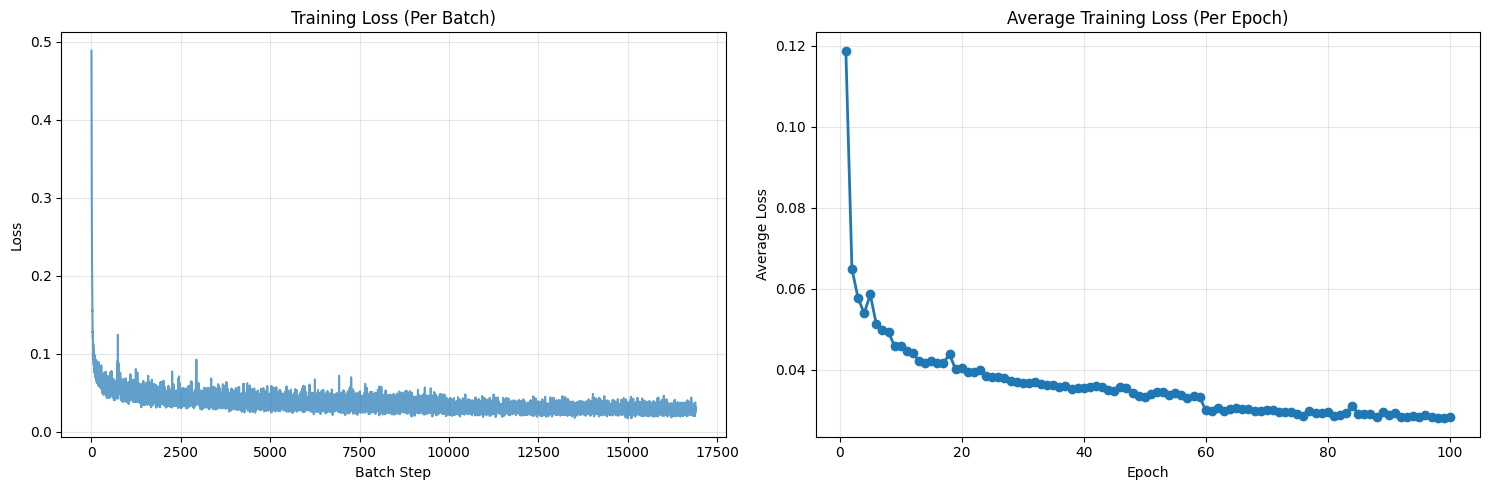

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot batch-wise losses
ax1.plot(train_losses, alpha=0.7)
ax1.set_title('Training Loss (Per Batch)')
ax1.set_xlabel('Batch Step')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

# Plot epoch-wise average losses
ax2.plot(range(1, len(epoch_losses) + 1), epoch_losses, 'o-', linewidth=2, markersize=6)
ax2.set_title('Average Training Loss (Per Epoch)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Loss')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6️⃣ Generating New Images (The Reverse Process)

Generating new images involves running the reverse process. We start with pure Gaussian noise (at timestep `T`) and iteratively apply our trained model to denoise it, one step at a time, until we reach timestep `0`.

The sampling process is summarized in the paper as Algorithm 2:

<img src="https://i.imgur.com/tTGrKg8.png" width="500" />

At each step `t`, the model predicts the noise $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$. We use this prediction to calculate the mean of the denoised image $\mathbf{x}_{t-1}$. Then, we add a small amount of variance (noise) back in, which is crucial for generating diverse samples.


In [32]:
# @torch.no_grad() 是一个装饰器，它会临时禁用梯度计算。
# 因为在推理（生成）阶段我们不需要计算梯度，这样做可以加速计算并节省内存。
@torch.no_grad()
def p_sample(model, x, t, t_index):
    """执行反向（采样）过程的一步。"""
    # 提取当前时间步 t 对应的 β_t 值
    betas_t = extract(betas, t, x.shape)
    # 提取 sqrt(1 - ᾱ_t)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    # 提取 1/sqrt(α_t)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # 这是论文中的公式11，用于计算去噪后图像的均值
    # model(x, t) 就是模型预测出的噪声 ε_θ
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    # 如果是最后一步 (t=0)，我们就不再添加噪声了，直接返回均值
    if t_index == 0:
        return model_mean
    else:
        # 如果不是最后一步，我们需要加入新的噪声来增加多样性
        # 提取后验方差 posterior_variance_t
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        # 生成与 x 形状相同的随机噪声
        noise = torch.randn_like(x)
        # 这是论文中的算法2第4行：返回均值 + sqrt(方差) * 新噪声
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# 算法2的完整实现（整个采样循环）
@torch.no_grad()
def p_sample_loop(model, shape):
    # 获取模型所在的设备
    device = next(model.parameters()).device
    # 获取要生成的图片数量 (批大小)
    b = shape[0]

    # 从纯粹的高斯噪声开始
    img = torch.randn(shape, device=device)
    # 创建一个列表来存储每一步的去噪结果（用于制作动画）
    imgs = []

    # 从 T-1 循环到 0，执行去噪过程
    for i in tqdm(reversed(range(0, TIMESTAMPS)), desc='Sampling Loop', total=TIMESTAMPS):
        # 调用 p_sample 执行一步去噪
        # torch.full(...) 创建一个用 i 填充的张量，作为时间步 t
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        # 将当前步的结果保存下来
        imgs.append(img.cpu().numpy())
    return imgs

# 一个方便调用的采样函数
@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    # 调用 p_sample_loop 来生成图像
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

### **🔹 Generating a Batch of Images**
Let's use our trained model to generate a grid of new anime faces.

Sampling Loop: 100%|██████████| 500/500 [00:02<00:00, 172.31it/s]


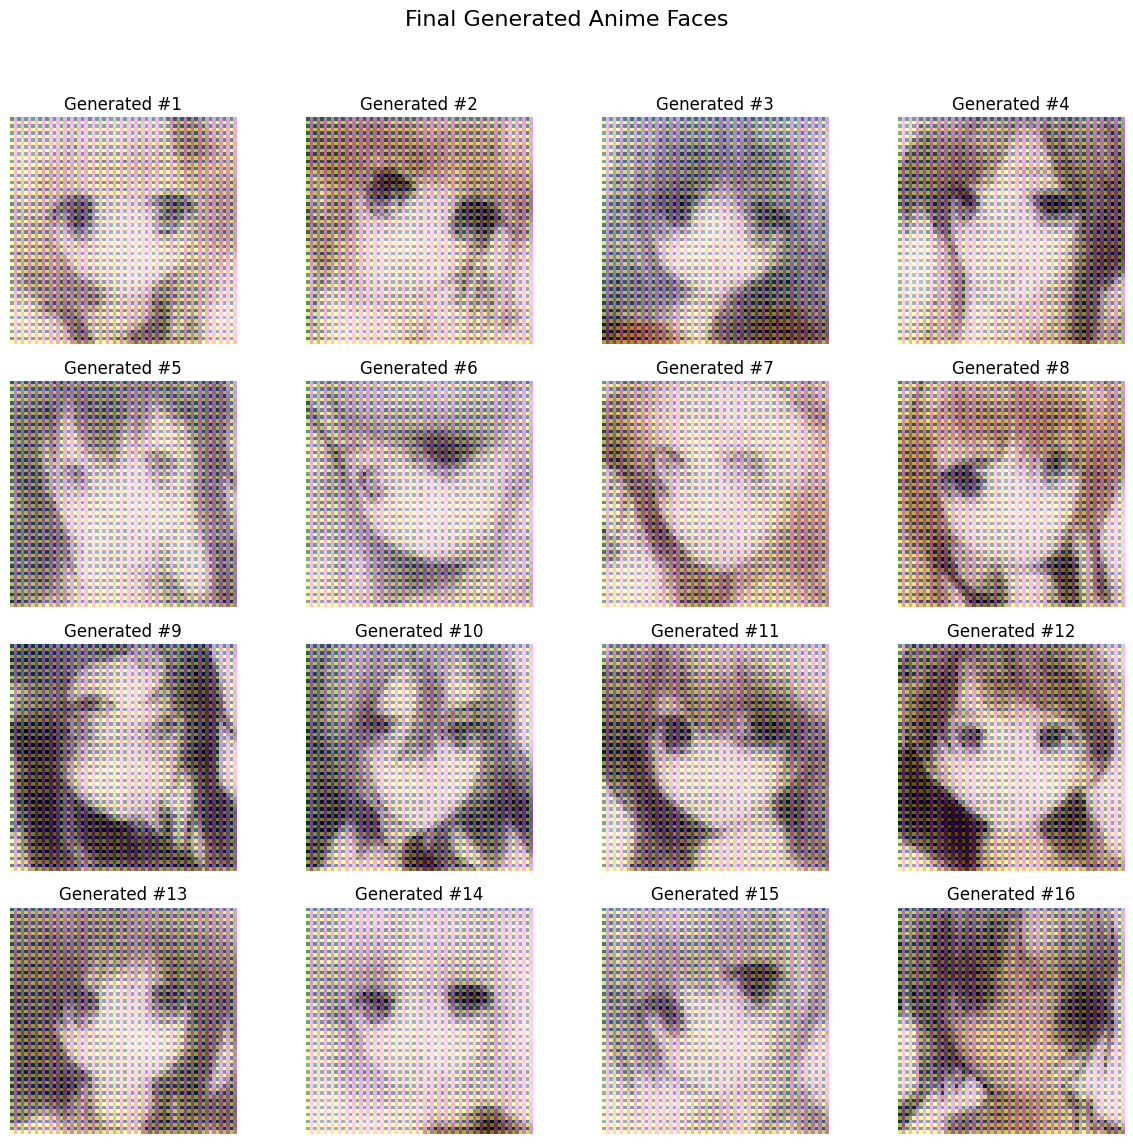

In [33]:
numberToGenerate = 16

# Sample 16 images
samples = sample(model, image_size=IMAGE_SIZE, batch_size=numberToGenerate, channels=3)

# The final generated images are at the last step of the sampling process
final_samples = samples[-1]

# Show all generated samples
figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4

for i in range(numberToGenerate):
    sample_img = final_samples[i]
    # Convert from [-1,1] to [0,1] and clamp to valid range
    sample_img = np.clip((sample_img + 1) / 2, 0, 1)

    figure.add_subplot(rows, cols, i + 1)
    plt.imshow(sample_img.transpose(1, 2, 0))
    plt.title(f"Generated #{i+1}")
    plt.axis('off')

plt.suptitle("Final Generated Anime Faces", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **🔹 Visualizing the Denoising Process**
We can create an animation to see how a single image evolves from pure noise to a recognizable face over the `T` sampling steps.

In [34]:
# Choose one of the generated samples to animate
random_index = 10

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = []
for i in range(TIMESTAMPS):
    # Get the image at step i for the chosen random_index
    sample_img = samples[i][random_index]
    # Convert from [-1,1] to [0,1] and clamp to valid range
    sample_img = np.clip((sample_img + 1) / 2, 0, 1)
    im = plt.imshow(sample_img.transpose(1, 2, 0), animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
rc('animation', html='jshtml')
animate

Output hidden; open in https://colab.research.google.com to view.

## 7️⃣ Conclusion & Next Steps

We have successfully built and trained a Denoising Diffusion Probabilistic Model (DDPM) to generate anime faces. We've seen how the model learns to reverse a fixed noising process to create new images from scratch.

### **📝 Exercises for Further Exploration**
1.  **Training Duration**: Train for more `EPOCHS`. Diffusion models benefit greatly from longer training. How do the results change after 200 or 500 epochs?
2.  **Timesteps**: Experiment with different `TIMESTAMPS` values (e.g., 200, 500, 1000). A larger `T` means a more gradual (and potentially more accurate) denoising process, but also slower sampling.
3.  **Beta Schedule**: The `linear_beta_schedule` is just one option. Research and implement other schedules, like a `cosine` schedule, which is often used in modern papers. How does it affect the final image quality?
4.  **Model Architecture**: Modify the U-Net. Try adding more ResNet-style blocks, using different attention mechanisms, or changing the number of channels (`64`, `128`, etc.) in the convolutional layers.
5.  **Dataset**: Try training this model on a different dataset, like CIFAR-10 or Fashion-MNIST. You will likely need to adjust the model architecture (e.g., `IMAGE_SIZE`, input channels) accordingly.

### Contributed by: Ali Habibullah.
